In [1]:
%matplotlib inline

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
df = pd.read_csv('200_500_str.csv')

In [3]:
df.head()

,sentences_500,label,sentences_200_str,sentences_500_str,sentences_100_str
0,"['ETF', '關鍵', '報告', '台北', '開課', '公告', '七月', '日...",10,ETF 關鍵 報告 台北 開課 公告 七月 日 課程 綠角將 七月 日 台北 開立 ETF ...,ETF 關鍵 報告 台北 開課 公告 七月 日 課程 綠角將 七月 日 台北 開立 ETF ...,ETF 關鍵 報告 台北 開課 公告 七月 日 課程 綠角將 七月 日 台北 開立 ETF ...
1,"['ETF', '關鍵', '報告', '台北', '開課', '公告', '九月', '課...",10,ETF 關鍵 報告 台北 開課 公告 九月 課程 此次 公告 九月 預計 台北 舉辦 兩個 ...,ETF 關鍵 報告 台北 開課 公告 九月 課程 此次 公告 九月 預計 台北 舉辦 兩個 ...,ETF 關鍵 報告 台北 開課 公告 九月 課程 此次 公告 九月 預計 台北 舉辦 兩個 ...
2,"['ETF', '關鍵', '報告', '台北', '開課', '公告', '八月', '日...",10,ETF 關鍵 報告 台北 開課 公告 八月 日 課程 綠角將 八月 日 台北 開立 ETF ...,ETF 關鍵 報告 台北 開課 公告 八月 日 課程 綠角將 八月 日 台北 開立 ETF ...,ETF 關鍵 報告 台北 開課 公告 八月 日 課程 綠角將 八月 日 台北 開立 ETF ...
3,"['訪客', '總覺', '這股', '應該', '慘', '公佈', '季營收', '下'...",10,訪客 總覺 這股 應該 慘 公佈 季營收 下 殺 明明 新聞 已經 說 月 營收 持平 市場...,訪客 總覺 這股 應該 慘 公佈 季營收 下 殺 明明 新聞 已經 說 月 營收 持平 市場...,訪客 總覺 這股 應該 慘 公佈 季營收 下 殺 明明 新聞 已經 說 月 營收 持平 市場...
4,"['lt', '圖片', '擷取', 'MONEYCONNEXION', 'gt', '雙親...",10,lt 圖片 擷取 MONEYCONNEXION gt 雙親 「 理財 身教 凡遇 錢 事 馬...,lt 圖片 擷取 MONEYCONNEXION gt 雙親 「 理財 身教 凡遇 錢 事 馬...,lt 圖片 擷取 MONEYCONNEXION gt 雙親 「 理財 身教 凡遇 錢 事 馬...


In [4]:
df.drop(df[pd.isnull(df['sentences_100_str'])].index, inplace=True)

In [6]:
df.drop(df[df['content'].str.len()<30].index, inplace=True)

In [5]:
df.shape

(73065, 5)

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

Using TensorFlow backend.


In [10]:
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 200


tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['sentences_100_str'])
sequences = tokenizer.texts_to_sequences(df['sentences_100_str'])


In [11]:
word_index = tokenizer.word_index

In [12]:
all_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(df['label']))
print('Shape of data tensor:', all_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (73065, 100)
Shape of label tensor: (73065, 14)


In [15]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(all_data,labels,
                                               test_size=0.3,
                                               stratify=labels,
                                              random_state = 22)


In [16]:
x_train.shape,y_train.shape

((51145, 100), (51145, 14))

#### CNN Model_1

In [ ]:
# from keras.layers import Dense, Input, Flatten, Dropout
# from keras.layers import Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D
# from keras.models import Sequential

# model = Sequential()
# model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
# model.add(Dropout(0.2))
# model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
# model.add(MaxPooling1D(3))
# model.add(Flatten())
# model.add(Dense(EMBEDDING_DIM, activation='relu'))
# model.add(Dense(labels.shape[1], activation='softmax'))
# model.summary()
# #plot_model(model, to_file='model.png',show_shapes=True)

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['acc'])
# print(model.metrics_names)

In [ ]:
# model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

#### CNN Model_2

In [18]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import multi_gpu_model
from keras.metrics import top_k_categorical_accuracy

In [19]:
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

epochs = 30
batch_size = 128


inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(inputs)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=labels.shape[1], activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=output)

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

def top_2_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2) 

#paralled_model = multi_gpu_model(model,2)
model.compile(optimizer=adam, 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy', top_2_categorical_accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 200)     57491000    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 200, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 1, 512)   307712      reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
# save weight
savePath = 'cnn_norm_100_top2.h5'
# paralled_model.save_weights('train_result/weights_model_cnntext-v2(71484).h5')

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(savePath, 
                             save_weights_only=True, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto')

earlystop = EarlyStopping(monitor='val_loss', 
                          patience=10, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', cooldown=0)

# 計算一個 epoch 總共要更新幾次參數
steps_per_epoch = len(y_train) // batch_size

# starts training
model_history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs, 
                          verbose=1, 
                          validation_data=(x_val, y_val),
                          callbacks=[earlystop,checkpoint]) 

Train on 51145 samples, validate on 21920 samples
Epoch 1/30
51072/51145 [============================>.] - ETA: 0s - loss: 2.3565 - acc: 0.2634 - top_2_categorical_accuracy: 0.3661
Epoch 00001: val_acc improved from -inf to 0.53987, saving model to cnn_norm_100_top2.h5
51145/51145 [==============================] - 37s 728us/step - loss: 2.3562 - acc: 0.2636 - top_2_categorical_accuracy: 0.3665 - val_loss: 1.9905 - val_acc: 0.5399 - val_top_2_categorical_accuracy: 0.6252
Epoch 2/30
51072/51145 [============================>.] - ETA: 0s - loss: 1.4496 - acc: 0.6520 - top_2_categorical_accuracy: 0.7676
Epoch 00002: val_acc improved from 0.53987 to 0.72806, saving model to cnn_norm_100_top2.h5
51145/51145 [==============================] - 34s 657us/step - loss: 1.4490 - acc: 0.6521 - top_2_categorical_accuracy: 0.7678 - val_loss: 1.0696 - val_acc: 0.7281 - val_top_2_categorical_accuracy: 0.8326
Epoch 3/30
51072/51145 [============================>.] - ETA: 0s - loss: 0.8612 - acc: 0.765

#### 加速 CNN model training speed

In [20]:
# # 用 generator餵資料，為了使用 fit_generator加速訓練速度

# def generate_batch_data_random(x, y, batch_size):
#     """逐步提取batch数据到显存，降低对显存的占用"""
#     ylen = len(y)
#     loopcount = ylen // batch_size
#     while (True):
#         i = np.random.randint(0,loopcount)
#         yield x[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size]

In [21]:
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
# # earlystop = Earlystopping(monitor='val_loss', patience=5, verbose=1)
# # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', cooldown=0)

# # 計算一個 epoch 總共要更新幾次參數
# steps_per_epoch = len(y_train) // batch_size

# # starts training
# model_history = model.fit_generator(generate_batch_data_random(x_train, y_train, batch_size),
#                                     workers=4,
#                                     steps_per_epoch=steps_per_epoch,
#                                     epochs=epochs, 
#                                     verbose=1, 
#                                     use_multiprocessing=True,
#                                     validation_data=(x_val, y_val))  

#### Score trained model

In [22]:
scores = paralled_model.evaluate(x_val, y_val, verbose=1)
print('Valid loss', scores[0])
print('Valid accuracy', scores[1])

20085/20085 [==============================] - 9s 452us/step
Valid loss 0.320720292889
Valid accuracy 0.903709235754


In [23]:
os.getcwd()

'/project/jt071-group23/jt071078'

#### Save training result

In [24]:
from keras.models import load_model

In [25]:
# save model
paralled_model.save('train_result/model_cnntext-v2(67178).h5')

In [26]:
# save history
with open('train_result/history_model_cnntext-v2(67178)', 'wb') as train_history:
    pickle.dump(model_history.history, train_history)

In [27]:
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

#### Plot performance

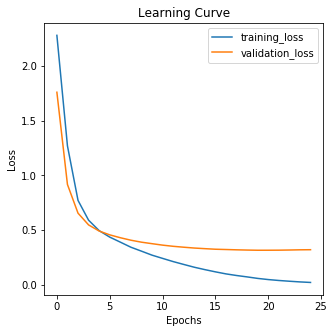

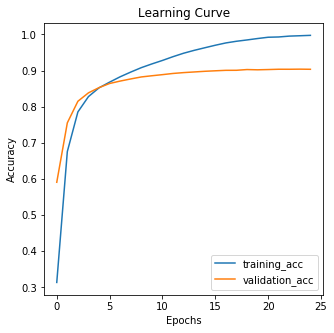

In [28]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

train_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.figure(figsize=(5,5))

plt.plot(training_loss, label='training_loss')
plt.plot(val_loss, label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend(loc='best')

plt.figure(figsize=(5,5))
#plt.subplot(122)
plt.plot(train_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
